In [22]:
using CSV
using Dates
using DelimitedFiles 
using PyPlot
using DIVAnd
using Statistics
const plt=PyPlot

PyPlot

In [2]:
using PyCall
using PyPlot
colors = PyCall.pyimport("matplotlib.colors")
ccrs = PyCall.pyimport("cartopy.crs")
cfeature = PyCall.pyimport("cartopy.feature")
mticker = PyCall.pyimport("matplotlib.ticker")
coast = cfeature.GSHHSFeature(scale="full");
cartopyticker = PyCall.pyimport("cartopy.mpl.ticker")
lon_formatter = cartopyticker.LongitudeFormatter()
lat_formatter = cartopyticker.LatitudeFormatter()
# mainproj = ccrs.PlateCarree()
cmocean = PyCall.pyimport("cmocean")

dom = [-22.5, 12.5, 40, 68.]
dlon = 5.
dlat = 5.
mainproj = ccrs.Mercator(central_longitude=0.5*(dom[1] + dom[2]),
    min_latitude=dom[3], max_latitude=dom[4])
datacrs = ccrs.PlateCarree()

PyObject <cartopy.crs.PlateCarree object at 0x7fb61f162360>

In [3]:
datadir = "../data/"
figdir = "../figures"
isdir(figdir) ? @debug("already there") : mkpath(figdir)
datafile = joinpath(datadir, "MBA_CPRdata_Emodnet_21Jan22.csv")
isfile(datafile) ? @debug("already downloaded") : download("https://dox.ulg.ac.be/index.php/s/hjWKf1F3C1Pzz1r/download", datafile)
bathfile = joinpath(datadir, "gebco_30sec_16.nc")
isfile(datafile), isfile(bathfile)

(true, true)

## Grid configuration

In [4]:
Δlon = 0.1
Δlat = 0.1
longrid = dom[1]:Δlon:dom[2]
latgrid = dom[3]:Δlat:dom[4]

40.0:0.1:68.0

### Metrics

In [18]:
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid)

(Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], ([9.999999999999858 9.999999999999858 … 9.999999999999858 9.999999999999858; 10.000000000000036 10.000000000000036 … 10.000000000000036 10.000000000000036; … ; 10.000000000000036 10.000000000000036 … 10.000000000000036 10.000000000000036; 10.000000000000036 10.000000000000036 … 10.000000000000036 10.000000000000036], [9.999999999999858 9.999999999999858 … 9.999999999999858 10.000000000000568; 9.999999999999858 9.999999999999858 … 9.999999999999858 10.000000000000568; … ; 9.999999999999858 9.999999999999858 … 9.999999999999858 10.000000000000568; 9.999999999999858 9.999999999999858 … 9.999999999999858 10.000000000000568]), ([-22.5 -22.5 … -22.5 -22.5; -22.4 -22.4 … -22.4 -22.4; … ; 12.4 12.4 … 12.4 12.4; 12.5 12.5 … 12.5 12.5], [40.0 40.1 … 67.9 68.0; 40.0 40.1 … 67.9 68.0; … ; 40.0 40.1 … 67.9 68.0; 40.0 40.1 … 67.9 68.0]))

### Prepare mask

In [5]:
bx, by, b = DIVAnd.load_bath(bathfile, true, longrid, latgrid)
@show size(b)

size(b) = (351, 281)


(351, 281)

In [6]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
pcm = ax.pcolormesh(bx, by, b', vmin=0., cmap=PyPlot.cm.gist_earth, transform=datacrs);
ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)

cb = plt.colorbar(pcm, orientation="vertical")
cb.set_label("Depth (m)", rotation=0, ha="left")
plt.savefig(joinpath(figdir, "domain_bathy_010"), dpi=300, bbox_inches="tight")
plt.close()

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/ctroupin/.julia/packages/PyCall/3fwVL/src/numpy.jl:67


In [7]:
_, (pm, pn),(xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
xi, yi, mask = DIVAnd.load_mask(bathfile, true, longrid, latgrid, 0.0);
xx, yy = DIVAnd.ndgrid(xi, yi);

In [8]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
pcm = ax.pcolormesh(bx, by, mask', cmap=PyPlot.cm.binary, transform=datacrs)
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)

plt.savefig(joinpath(figdir, "domain_mask_010"), dpi=300, bbox_inches="tight")
plt.close()

## Data reading

In [9]:
data = readdlm(datafile, ',', skipstart=1);

In [10]:
lon = data[:,3]
lat = data[:,2]
year = data[:,4]
month = data[:,5]
thedates = Date.(year, month)
calanus_finmarchicus = data[:,6]
calanus_helgolandicus = data[:,7];

In [11]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
plt.hist(thedates, bins=12 * 6, rwidth=.7, color=".3")
plt.savefig(joinpath(figdir, "time_histogram"), dpi=300, bbox_inches="tight")
plt.close()

## Spatial distribution

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
ax.plot(lon, lat, "ko", markersize=1, transform=datacrs)
ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)
ax.set_title("Locations of the observations")
plt.savefig(joinpath(figdir, "location_obs"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

### Finmarchicus

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
scat = ax.scatter(lon, lat, s=2, c=calanus_finmarchicus, cmap=plt.cm.hot_r, vmax=50.,
                  transform=datacrs)
cb = plt.colorbar(scat, extend="max")

ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)
ax.set_title("Calanus_finmarchicus observations")

plt.savefig(joinpath(figdir, "count_calanus_finmarchicus"), dpi=300, bbox_inches="tight")

plt.close()

#### Location of zeros

In [63]:
length(lonz1)/length(lon), length(latz2)/length(lat)

(0.7259951559271474, 0.6285184526334515)

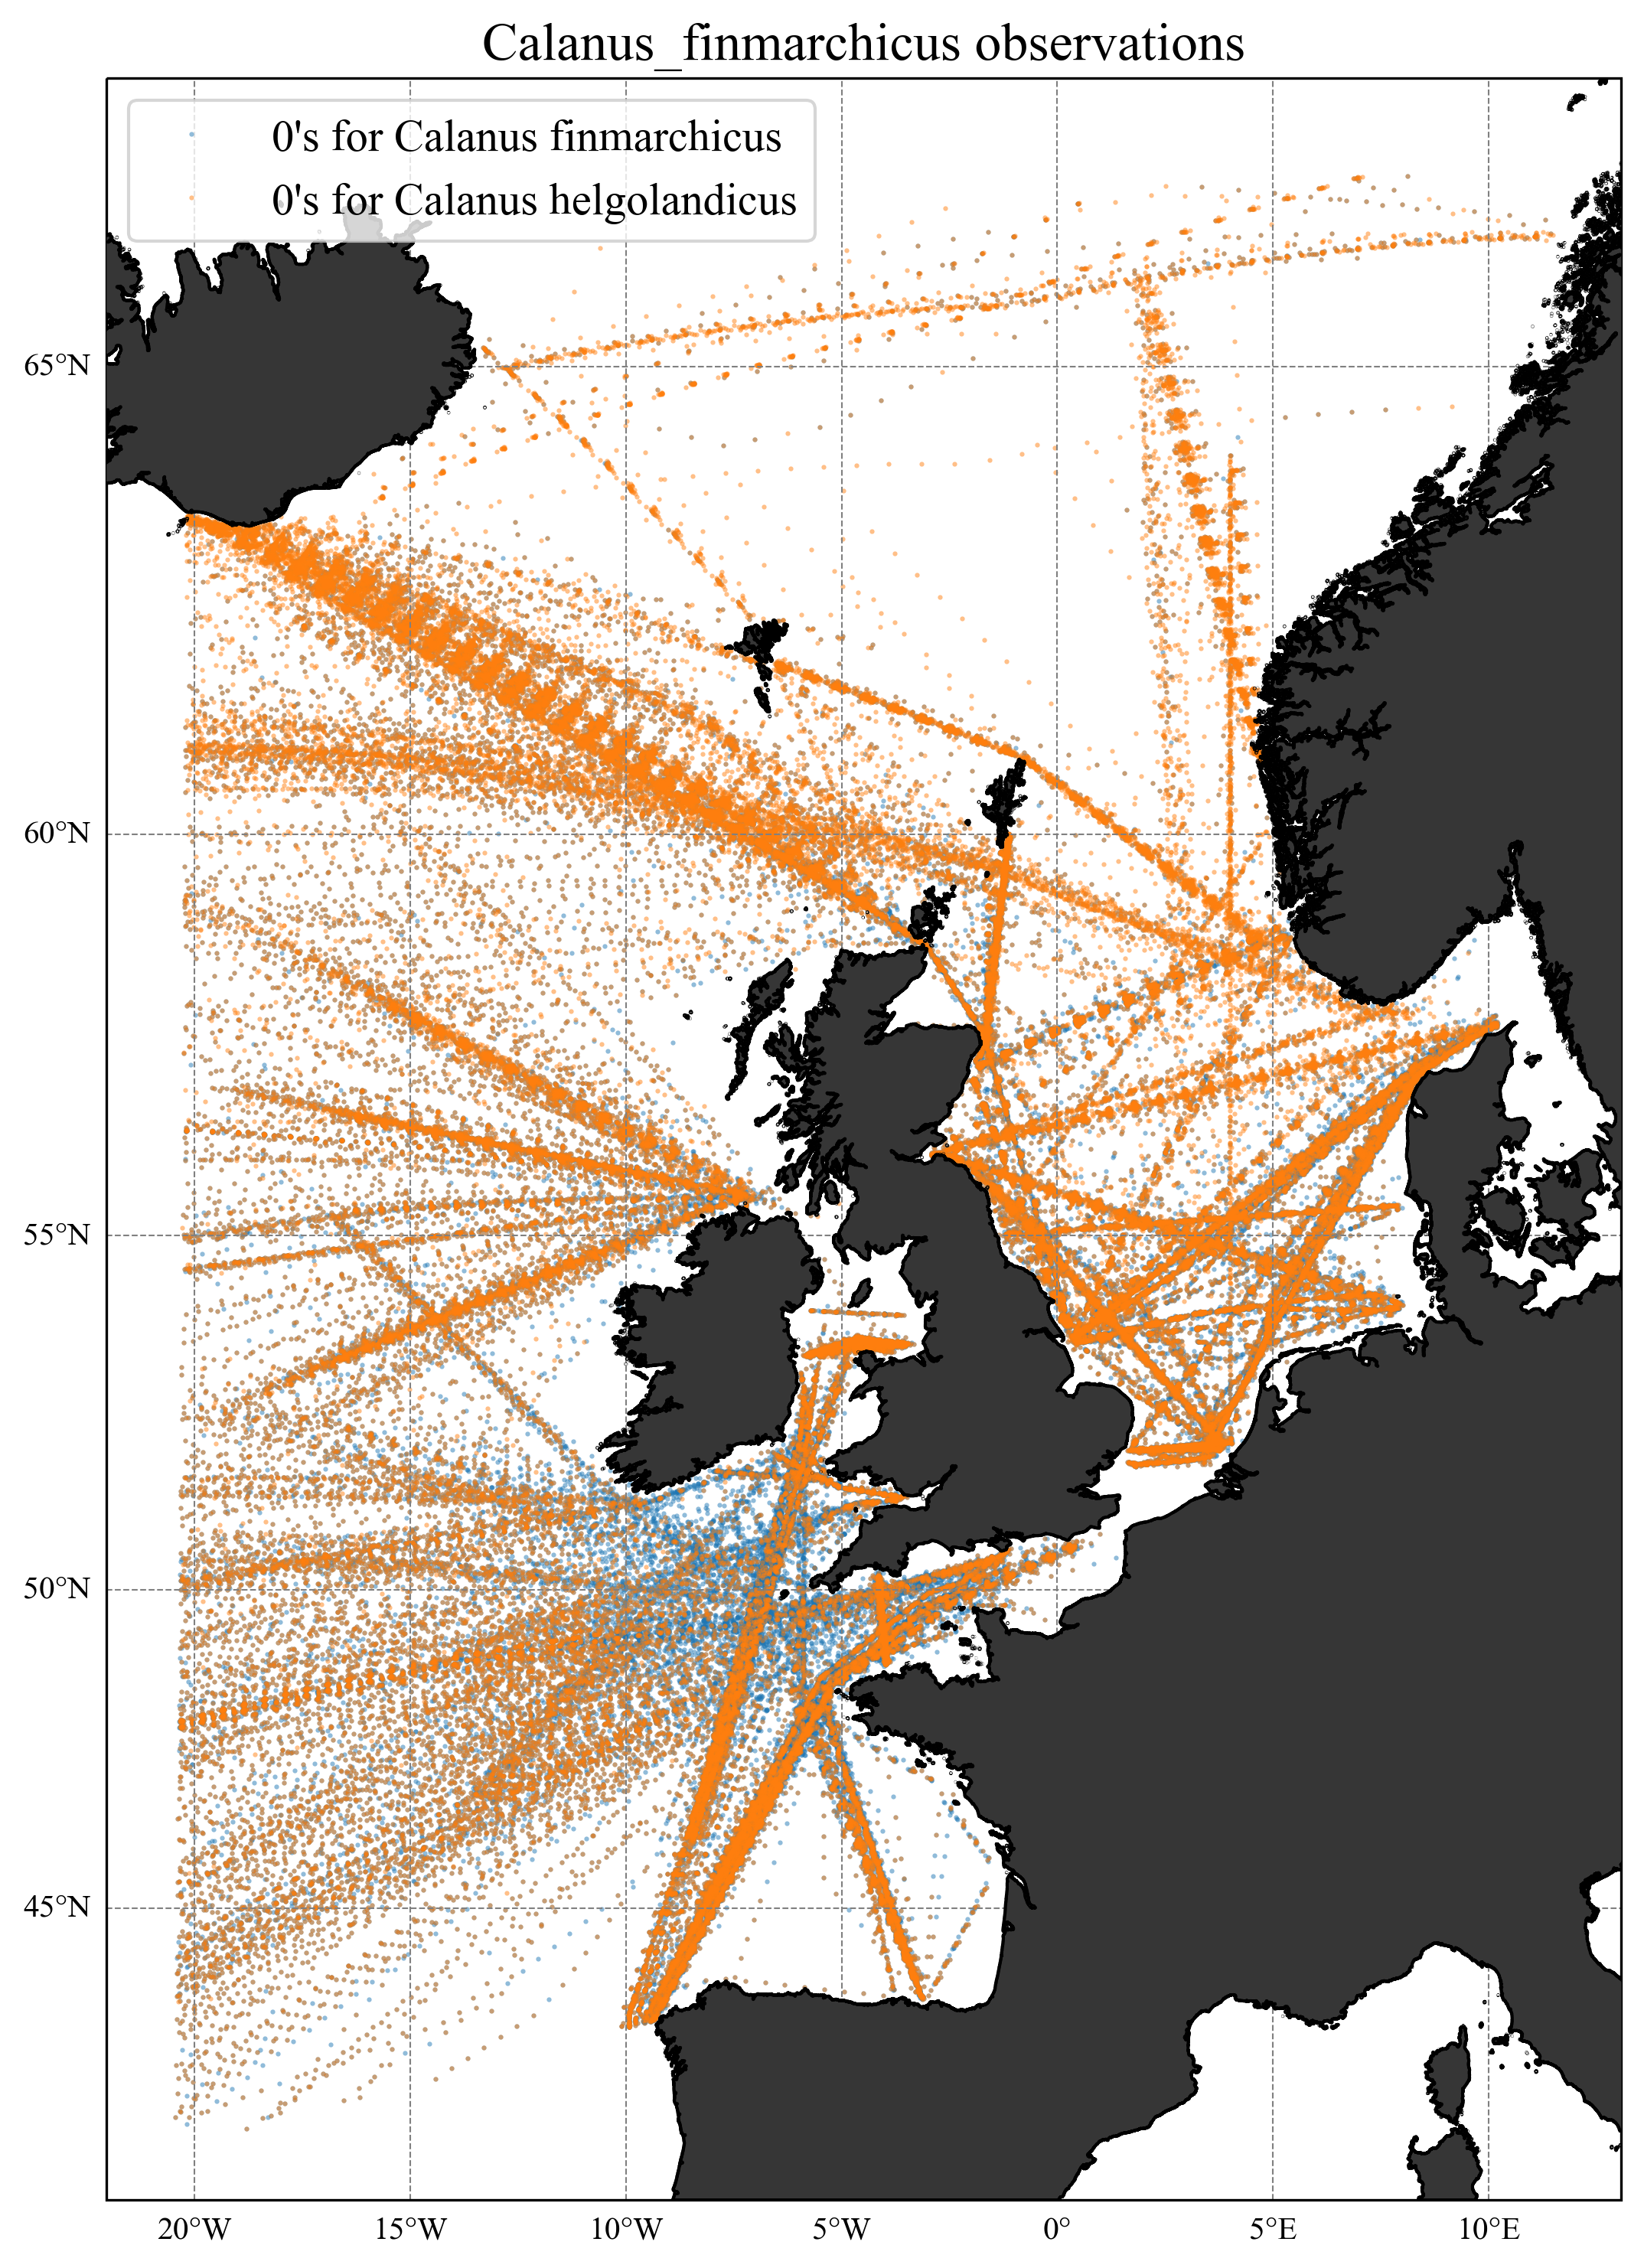

In [64]:
zerosloc1 = findall(calanus_finmarchicus .== 0.)
lonz1 = lon[zerosloc1]
latz1 = lat[zerosloc1]
zerosloc2 = findall(calanus_helgolandicus .== 0.)
lonz2 = lon[zerosloc2]
latz2 = lat[zerosloc2]

fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
ax.plot(lonz1, latz1, "o", ms=.5, alpha=.5, transform=datacrs, label="0's for Calanus finmarchicus")
ax.plot(lonz2, latz2, "o", ms=.5, alpha=.5, transform=datacrs, label="0's for Calanus helgolandicus")

ax.legend()

ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)
ax.set_title("Calanus_finmarchicus observations")

#plt.savefig(joinpath(figdir, "count_calanus_finmarchicus"), dpi=300, bbox_inches="tight")

plt.show()

#### Calanus helgolandicus

In [14]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
scat = ax.scatter(lon, lat, s=2, c=calanus_helgolandicus, cmap=plt.cm.hot_r, vmax=50.,
                  transform=datacrs)
cb = plt.colorbar(scat, extend="max")

ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)
ax.set_title("Calanus helgolandicus observations")

plt.savefig(joinpath(figdir, "count_calanus_helgolandicus"), dpi=300, bbox_inches="tight")

plt.close()

## Analysis
### All data together

In [70]:
L = 2.5
epsilon2 = 5.
f_finmarchicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon, lat), 
    calanus_finmarchicus .- mean(calanus_finmarchicus), (L, L), epsilon2);
f_helgolandicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon, lat), 
    calanus_helgolandicus .- mean(calanus_helgolandicus), (L, L), epsilon2);

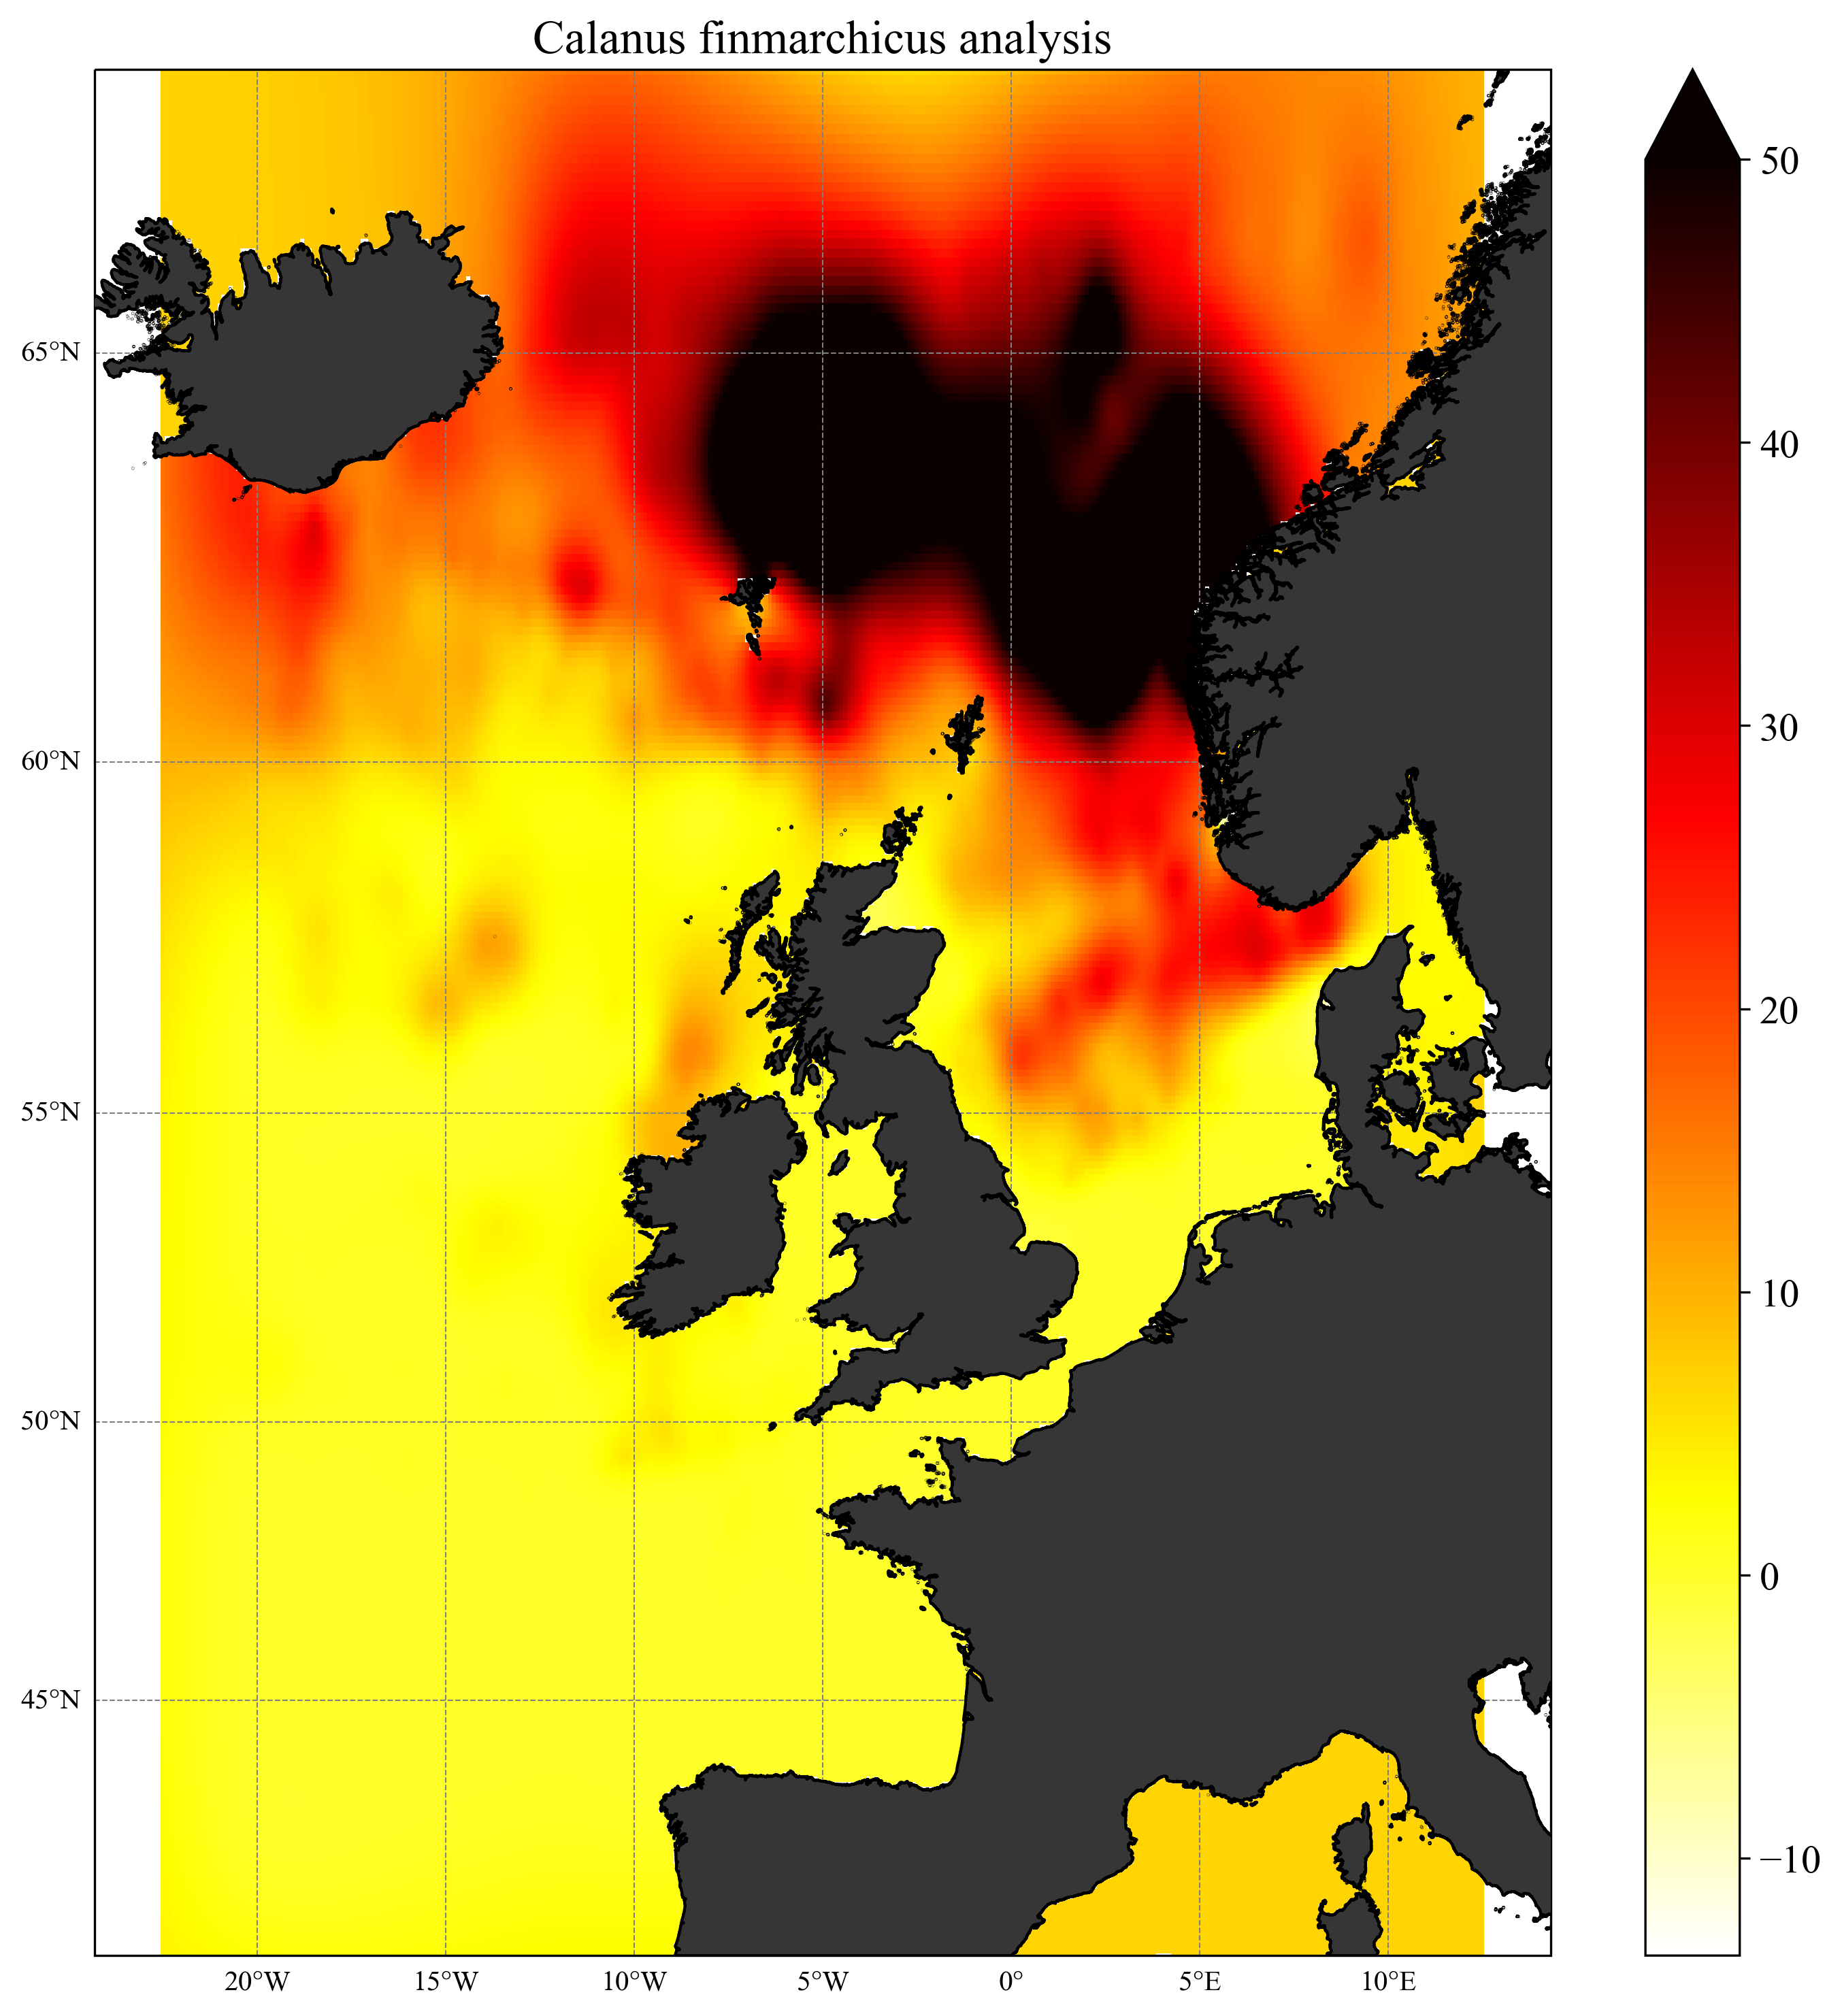

In [73]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
pcm = ax.pcolormesh(longrid, latgrid, f_finmarchicus' .+ mean(calanus_finmarchicus), 
        cmap=plt.cm.hot_r, vmax=50., transform=datacrs)
cb = plt.colorbar(pcm, extend="max")

ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)
ax.set_title("Calanus finmarchicus analysis")

# plt.savefig(joinpath(figdir, "count_calanus_helgolandicus"), dpi=300, bbox_inches="tight")

plt.show()

# plt.close()

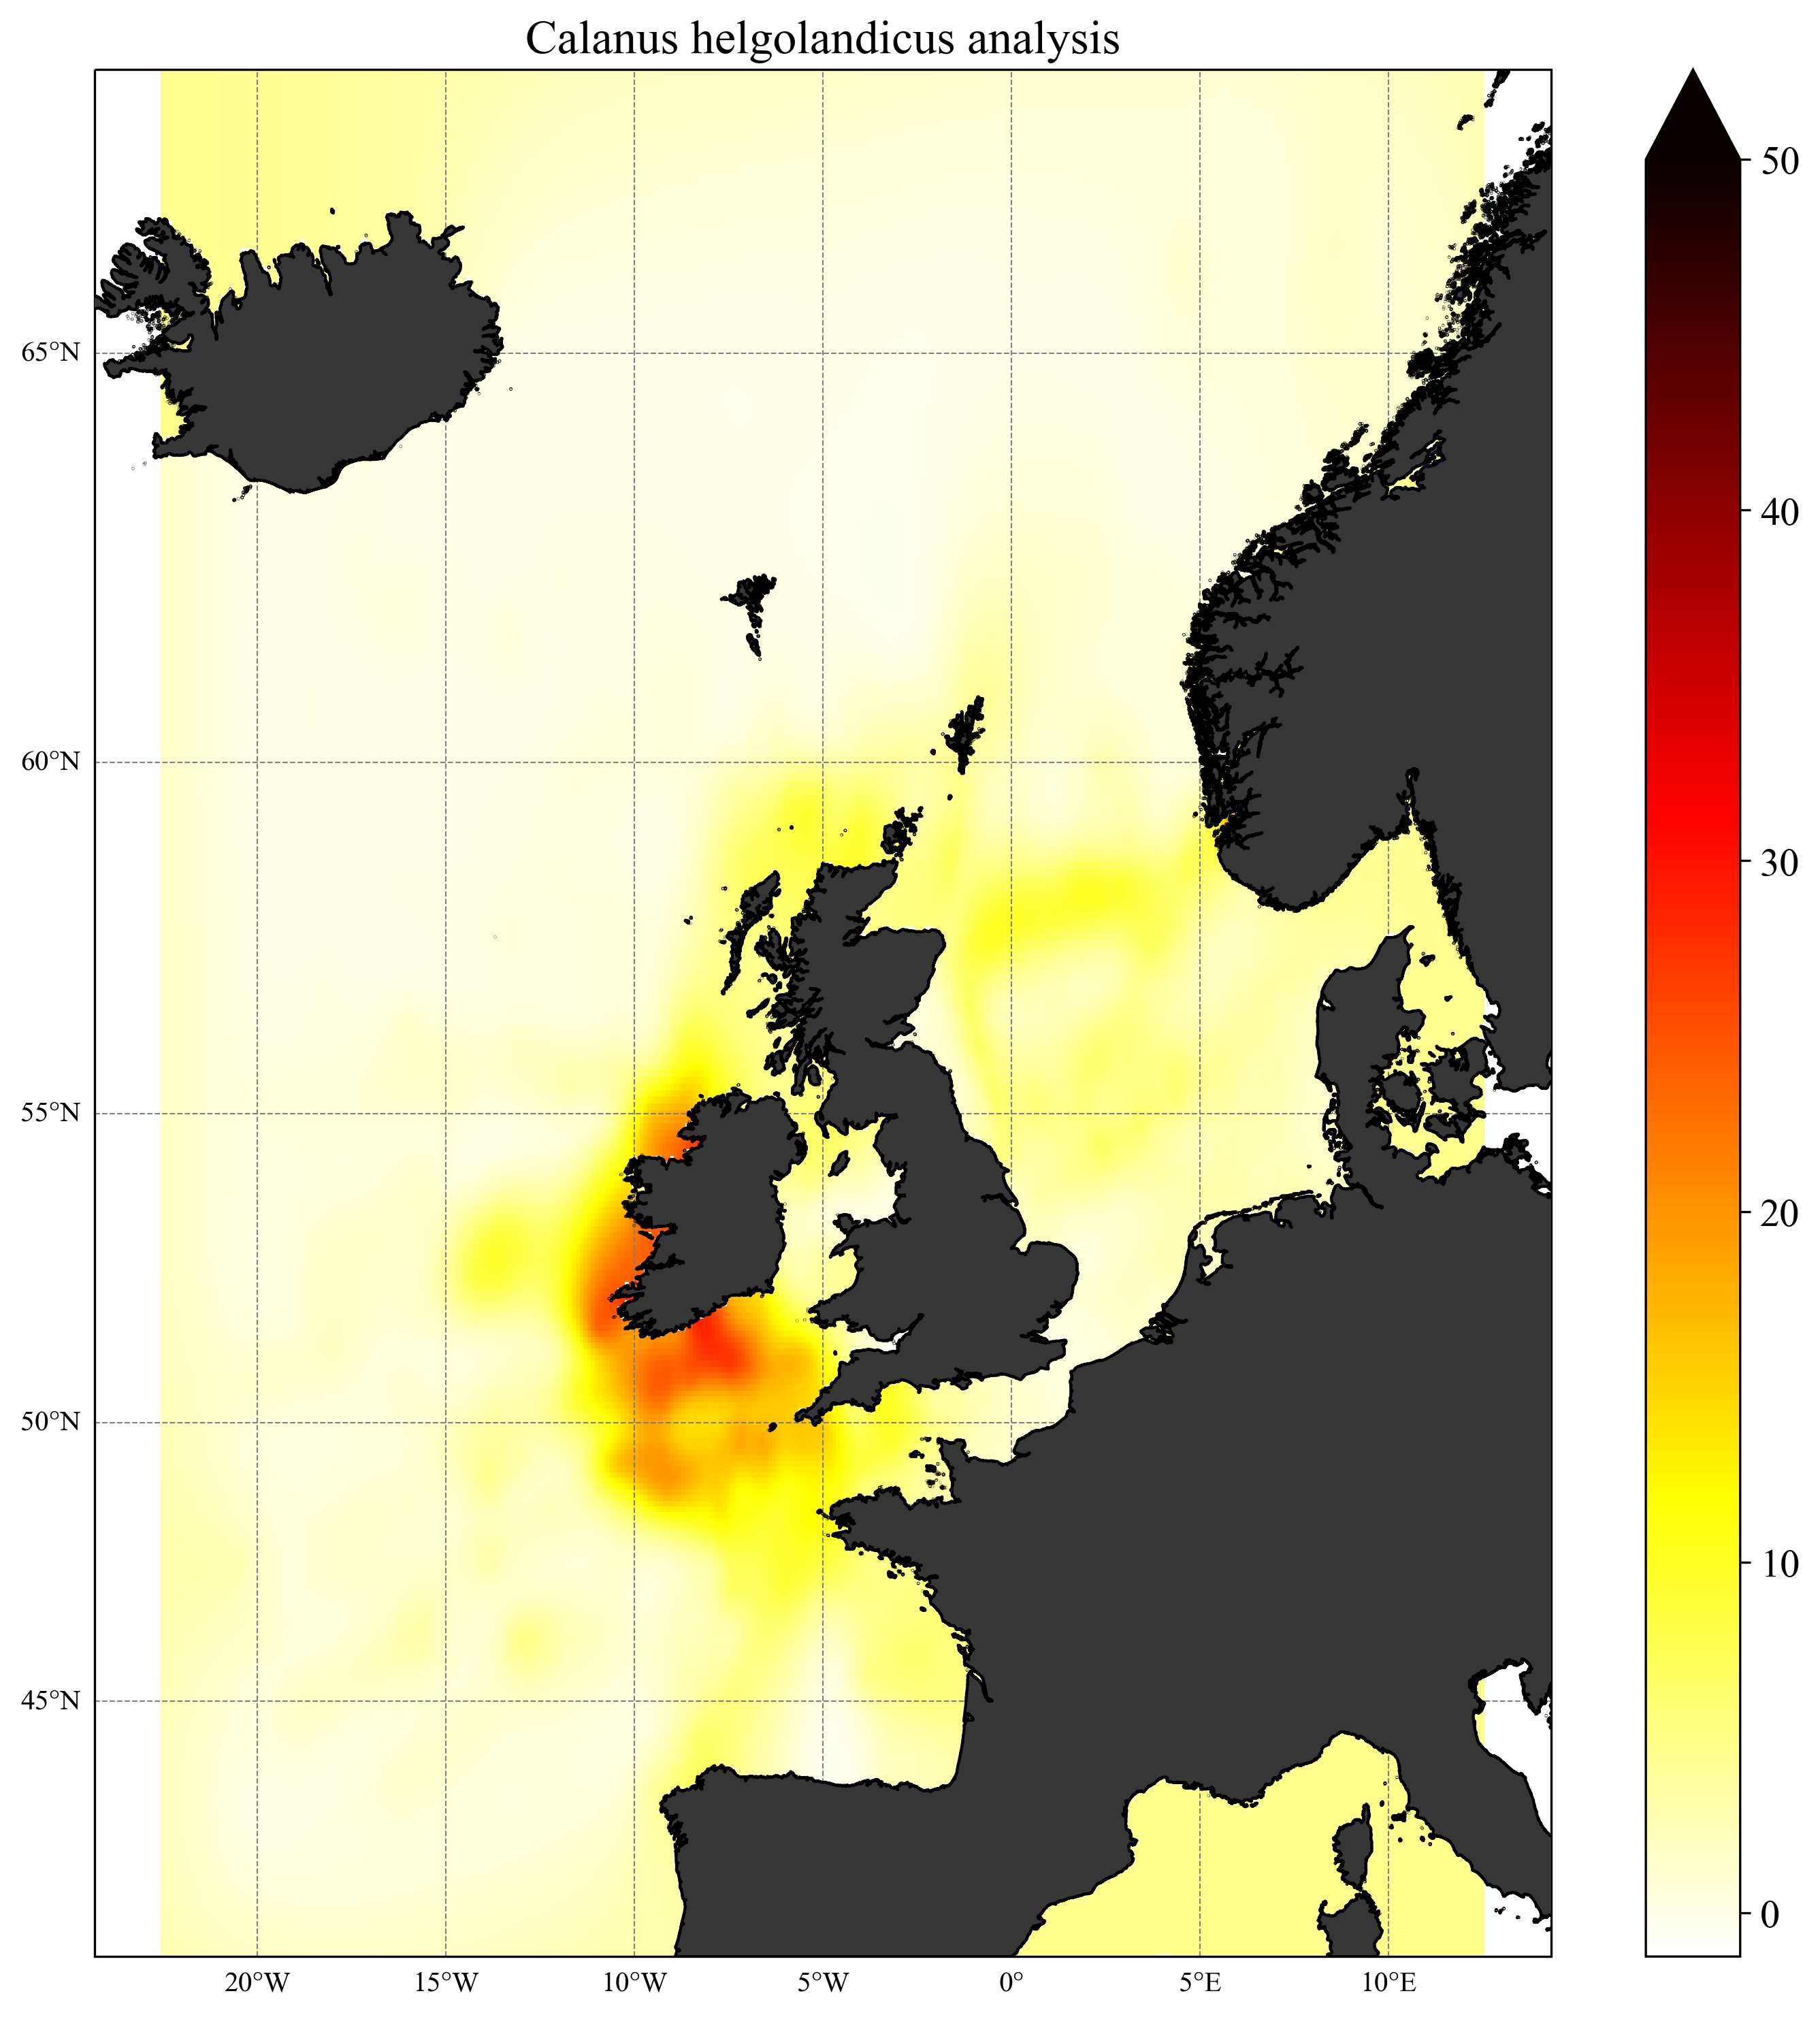

In [74]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
pcm = ax.pcolormesh(longrid, latgrid, f_helgolandicus' .+ mean(calanus_helgolandicus), 
        cmap=plt.cm.hot_r, vmax=50., transform=datacrs)
cb = plt.colorbar(pcm, extend="max")

ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)
ax.set_title("Calanus helgolandicus analysis")

# plt.savefig(joinpath(figdir, "count_calanus_helgolandicus"), dpi=300, bbox_inches="tight")

plt.show()

# plt.close()